In [1]:
import pandas as pd
from scikeras.wrappers import KerasRegressor
import numpy as np

2024-11-03 03:44:58.373588: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-03 03:44:58.840982: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-03 03:44:59.931380: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Open master df

In [2]:
# Open master
df= pd.read_feather('../data/processed/master.feather')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11323393 entries, 0 to 11323392
Data columns (total 13 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   searchDate                  datetime64[ns]
 1   flightDate                  datetime64[ns]
 2   startingAirport             object        
 3   destinationAirport          object        
 4   isNonStop                   bool          
 5   totalFare                   float32       
 6   segmentsArrivalAirportCode  object        
 7   DepartureTimeHour           uint8         
 8   CabinCode                   float32       
 9   AirlineNameScore            uint8         
 10  date_diff_days              uint16        
 11  weekday_sin                 float32       
 12  weekday_cos                 float32       
dtypes: bool(1), datetime64[ns](2), float32(4), object(3), uint16(1), uint8(2)
memory usage: 658.7+ MB


# Keep only the cheapest flight for a particular day and hour for the features used for training

In [4]:
# Remove row so only the cheapest for the feature set is kept
features_column = ['searchDate', 'flightDate', 'startingAirport', 'destinationAirport', 'isNonStop', 'DepartureTimeHour', 'CabinCode', 'AirlineNameScore', 'date_diff_days']
df_cheapest = df.sort_values('totalFare').drop_duplicates(features_column).sort_index()
df_cheapest.shape

(6569260, 13)

## Plot date accross date

<Axes: xlabel='flightDate'>

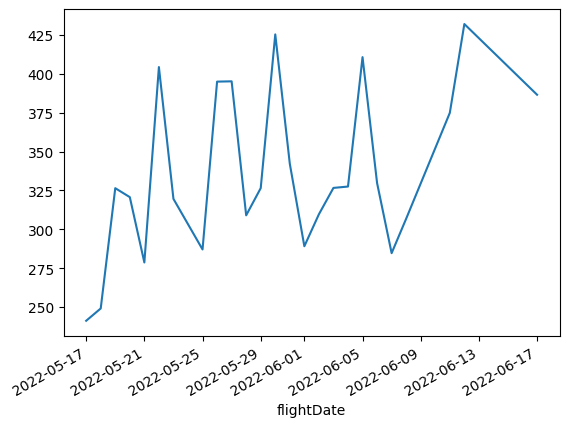

In [5]:
# Plot the average price for each flight date with date_diff_days of 5
df_cheapest[df_cheapest['date_diff_days'] == 30].groupby('flightDate')['totalFare'].mean().plot()
# df_cheapest.groupby('flightDate')['totalFare'].mean().plot()



# Modelling

Steps
1. Encode the categories
2. Normalise
3. Split and train
4. train 
5. Eval

### Preprocess data

In [ ]:
# Encode Categories using scikitlearn pipeline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import joblib
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model

# Define the features and target
X = df_cheapest.drop(['totalFare', 'searchDate', 'flightDate','segmentsArrivalAirportCode'], axis=1)
y = df_cheapest['totalFare']

#Label encode for airports
le = LabelEncoder()
le.fit(X['startingAirport'])
le.fit(X['destinationAirport'])


# Encode both columns using the same encoder
X['startingAirport'] = le.transform(X['startingAirport'])
X['destinationAirport'] = le.transform(X['destinationAirport'])

# Encode the boolean column
X['isNonStop'] = X['isNonStop'].astype(int)



# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Scale the data
scaler = StandardScaler()
scale_col = ['DepartureTimeHour', 'CabinCode', 'AirlineNameScore', 'date_diff_days']
X_train[scale_col] = scaler.fit_transform(X_train[scale_col])
X_test[scale_col] = scaler.transform(X_test[scale_col])






<KerasTensor shape=(None, 1, 5), dtype=float32, sparse=False, name=keras_tensor>


2024-11-03 03:45:13.871495: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-03 03:45:14.077901: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ startingAirport     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ destinationAirport  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 5)      │         80 │ startingAirport[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 5)      │         80 │ destinationAirpo… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 5)         │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 5)         │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ otherFeatures       │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 17)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ otherFeatures[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      2,304 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,785 (42.13 KB)

 Trainable params: 10,785 (42.13 KB)

 Non-trainable params: 0 (0.00 B)

Unique values in startingAirport: [ 0  1  3  4  6  8  9 10 11 12 13 14 15]
Unique values in destinationAirport: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15  0]
Epoch 1/10


/home/raytechie/Projects/adv_mla_at3/ml_experimentation/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['startingAirport', 'destinationAirport', 'otherFeatures']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


164222/164232 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 18183.1230

/home/raytechie/Projects/adv_mla_at3/ml_experimentation/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['startingAirport', 'destinationAirport', 'otherFeatures']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


164232/164232 ━━━━━━━━━━━━━━━━━━━━ 189s 1ms/step - loss: 18182.9238 - val_loss: 13552.7197
Epoch 2/10
164232/164232 ━━━━━━━━━━━━━━━━━━━━ 189s 1ms/step - loss: 13218.4766 - val_loss: 13248.1211
Epoch 3/10
164232/164232 ━━━━━━━━━━━━━━━━━━━━ 188s 1ms/step - loss: 12938.0508 - val_loss: 12849.9082
Epoch 4/10
164232/164232 ━━━━━━━━━━━━━━━━━━━━ 192s 1ms/step - loss: 12715.9531 - val_loss: 12878.9619
Epoch 5/10
164232/164232 ━━━━━━━━━━━━━━━━━━━━ 346s 2ms/step - loss: 12625.7773 - val_loss: 12568.0723
Epoch 6/10
164232/164232 ━━━━━━━━━━━━━━━━━━━━ 191s 1ms/step - loss: 12483.6855 - val_loss: 12571.3877
Epoch 7/10
164232/164232 ━━━━━━━━━━━━━━━━━━━━ 192s 1ms/step - loss: 12430.2061 - val_loss: 12524.3350
Epoch 8/10
164232/164232 ━━━━━━━━━━━━━━━━━━━━ 193s 1ms/step - loss: 12324.0088 - val_loss: 12367.4512
Epoch 9/10
164232/164232 ━━━━━━━━━━━━━━━━━━━━ 191s 1ms/step - loss: 12393.8232 - val_loss: 12366.8164
Epoch 10/10
164232/164232 ━━━━━━━━━━━━━━━━━━━━ 192s 1ms/step - loss: 12280.6689 - val_loss: 1

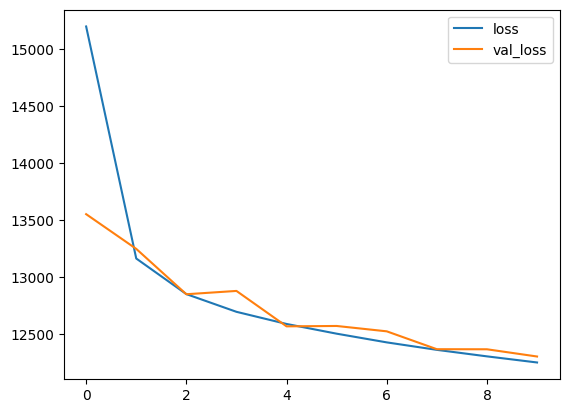

In [7]:
########################################################################################################################
# 2. Define the models
########################################################################################################################

# # Linear Regression
# linear_regression = LinearRegression()

# # LightGBM

# lgbm = LGBMRegressor()

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Define a function to create the Keras model
def create_model():
    startingAirport_input = Input(shape=(1,), name='startingAirport')
    destinationAirport_input = Input(shape=(1,), name='destinationAirport')
    other_features_input = Input(shape=(X_train.shape[1] - 2,), name='otherFeatures')

    startingAirport_embedding = Embedding(input_dim=X['startingAirport'].max() + 1 , output_dim=5)(startingAirport_input)
    destinationAirport_embedding = Embedding(input_dim=X['destinationAirport'].max() + 1, output_dim=5)(destinationAirport_input)
    # print dimensions
    print(startingAirport_embedding)
    startingAirport_flatten = Flatten()(startingAirport_embedding)
    destinationAirport_flatten = Flatten()(destinationAirport_embedding)

    concat = Concatenate()([startingAirport_flatten, destinationAirport_flatten, other_features_input])

    dense1 = Dense(128, activation='relu')(concat)
    dense2 = Dense(64, activation='relu')(dense1)
    output = Dense(1)(dense2)

    model = Model(inputs=[startingAirport_input, destinationAirport_input, other_features_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model
# Create the model
model = create_model()

# Print the model summary
model.summary()
# Check unique values in startingAirport and destinationAirport columns
print("Unique values in startingAirport:", X['startingAirport'].unique())
print("Unique values in destinationAirport:", X['destinationAirport'].unique())

# # Ensure the input data is correctly formatted
# X_train_formatted = [X_train['startingAirport'], X_train['destinationAirport'], X_train.drop(columns=['startingAirport', 'destinationAirport'])]
# X_test_formatted = [X_test['startingAirport'], X_test['destinationAirport'], X_test.drop(columns=['startingAirport', 'destinationAirport'])]
# # print(X_train_formatted[0].shape, X_train_formatted[1].shape, X_train_formatted[2].shape) #to verify they're consistent.
# # Print debug information
# # print("X_train_formatted shapes:", [x.shape for x in X_train])
# # print("X_train_formatted types:", [type(x) for x in X_train])
# # print("X_test_formatted shapes:", [x.shape for x in X_train])
# # print("X_test_formatted types:", [type(x) for x in X_train])

# # # Check for NaN or infinite values
# # print("NaN values in X_train_formatted:", [np.isnan(x).any() for x in X_train])
# # print("Infinite values in X_train_formatted:", [np.isinf(x).any() for x in X_train])

# # # Print sample data
# # print("Sample X_train_formatted:", [x[:5] for x in X_train])
# # print("Sample y_train:", y_train[:5])

# Prepare the input data
X_train_formatted = [X_train['startingAirport'], X_train['destinationAirport'], X_train.drop(['startingAirport', 'destinationAirport'], axis=1)]
X_test_formatted = [X_test['startingAirport'], X_test['destinationAirport'], X_test.drop(['startingAirport', 'destinationAirport'], axis=1)]

# Train the model with the correct input format
history = model.fit(
    X_train_formatted,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_formatted, y_test)
)

# Evaluate the model
score = model.evaluate(X_test_formatted, y_test)
print("Score:", score)

# Plot learning curve
pd.DataFrame(history.history).plot()
plt.show()

In [10]:
# Save the model
model.save('../models/keras_model.keras')

# Save the scaler
joblib.dump(scaler, '../models/scaler.pkl')

# Save the encoder
joblib.dump(le, '../models/encoder.pkl')





['../models/encoder.pkl']

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Continue training the model with EarlyStopping
history = model.fit(
    X_train_formatted,
    y_train,
    epochs=50,  # Additional epochs
    batch_size=32,
    validation_data=(X_test_formatted, y_test),
    callbacks=[early_stopping]  # Add the EarlyStopping callback
)

# save the model
model.save('../models/keras_model_early_stopping.keras')



Epoch 1/50
164232/164232 ━━━━━━━━━━━━━━━━━━━━ 197s 1ms/step - loss: 12198.1426 - val_loss: 12286.6406
Epoch 2/50
164232/164232 ━━━━━━━━━━━━━━━━━━━━ 193s 1ms/step - loss: 12128.6777 - val_loss: 12253.0566
Epoch 3/50
164232/164232 ━━━━━━━━━━━━━━━━━━━━ 191s 1ms/step - loss: 12171.8193 - val_loss: 12229.1816
Epoch 4/50
164232/164232 ━━━━━━━━━━━━━━━━━━━━ 189s 1ms/step - loss: 12068.6211 - val_loss: 12094.1572
Epoch 5/50
164232/164232 ━━━━━━━━━━━━━━━━━━━━ 27119s 165ms/step - loss: 12002.9824 - val_loss: 12281.0625
Epoch 6/50
164232/164232 ━━━━━━━━━━━━━━━━━━━━ 258s 2ms/step - loss: 11998.9727 - val_loss: 12233.1533
Epoch 7/50
164232/164232 ━━━━━━━━━━━━━━━━━━━━ 527s 3ms/step - loss: 11980.1660 - val_loss: 12137.7490
Epoch 8/50
164232/164232 ━━━━━━━━━━━━━━━━━━━━ 188s 1ms/step - loss: 11983.4648 - val_loss: 12147.6406
Epoch 9/50
164232/164232 ━━━━━━━━━━━━━━━━━━━━ 191s 1ms/step - loss: 11919.3018 - val_loss: 12095.6143


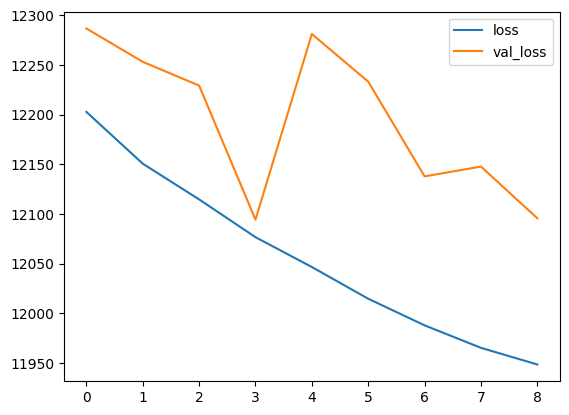

In [13]:
# Plot learning curve
pd.DataFrame(history.history).plot()
plt.show()

In [14]:
predictions = model.predict(X_test_formatted)
predictions = predictions.flatten()
# Calculate the mean absolute error
mae = np.mean(np.abs(predictions - y_test))
print("Mean Absolute Error:", mae)

# Calculate the mean absolute percentage error
mape = np.mean(np.abs(predictions - y_test) / y_test)
print("Mean Absolute Percentage Error:", mape)

# Calculate the root mean squared error
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print("Root Mean Squared Error:", rmse)



41058/41058 ━━━━━━━━━━━━━━━━━━━━ 36s 868us/step
Mean Absolute Error: 72.93785
Mean Absolute Percentage Error: 0.26078165
Root Mean Squared Error: 109.97325


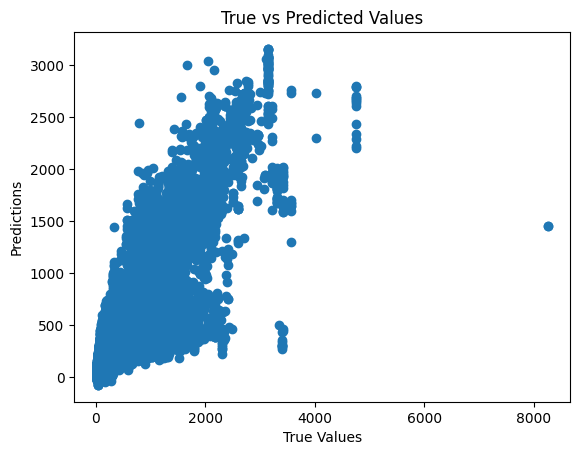

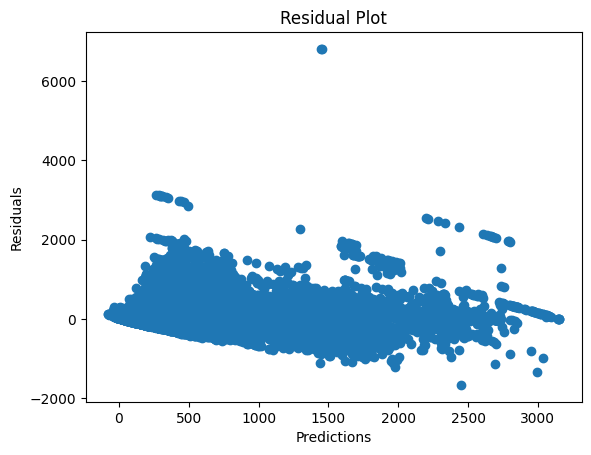

In [15]:
import matplotlib.pyplot as plt

# Scatter plot of true vs predicted values
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.show()

# Residual plot
residuals = y_test - predictions
plt.scatter(predictions, residuals)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

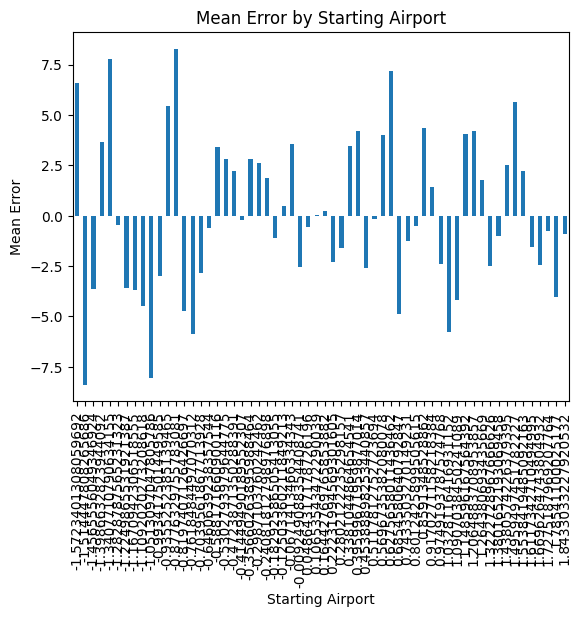

In [20]:
# Group errors by a specific feature (e.g., 'startingAirport')
error_df = pd.DataFrame({'True': y_test, 'Predicted': predictions, 'Error': y_test - predictions})
grouped_errors = error_df.groupby(X_test['date_diff_days']).mean()

# Plot mean error by 'startingAirport'
grouped_errors['Error'].plot(kind='bar')
plt.xlabel('Starting Airport')
plt.ylabel('Mean Error')
plt.title('Mean Error by Starting Airport')
plt.show()

I think its handling outlier predictions badly like regional (which might involve more distance). Its also confused by the cabin code

In [29]:
import numpy as np
from tensorflow.keras.models import Model

# Extract the embedding layers
starting_airport_embedding_layer = model.get_layer('embedding')
destination_airport_embedding_layer = model.get_layer('embedding_1')

# Create models to output the embeddings
starting_airport_embedding_model = Model(inputs=model.input, outputs=starting_airport_embedding_layer.output)
destination_airport_embedding_model = Model(inputs=model.input, outputs=destination_airport_embedding_layer.output)

# Get the weights of the embedding layers
starting_airport_embeddings = starting_airport_embedding_layer.get_weights()[0]
destination_airport_embeddings = destination_airport_embedding_layer.get_weights()[0]

# Rename the airport indexes using le

starting_airport_index = {i: le.inverse_transform([i])[0] for i in range(starting_airport_embeddings.shape[0])}
destination_airport_index = {i: le.inverse_transform([i])[0] for i in range(destination_airport_embeddings.shape[0])}


In [30]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# Check the number of samples in the embeddings
num_samples_starting = starting_airport_embeddings.shape[0]
num_samples_destination = destination_airport_embeddings.shape[0]

# Set perplexity to a value less than the number of samples
perplexity_value = min(num_samples_starting, num_samples_destination) - 1

# Reduce dimensionality of embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
starting_airport_embeddings_2d = tsne.fit_transform(starting_airport_embeddings)
destination_airport_embeddings_2d = tsne.fit_transform(destination_airport_embeddings)

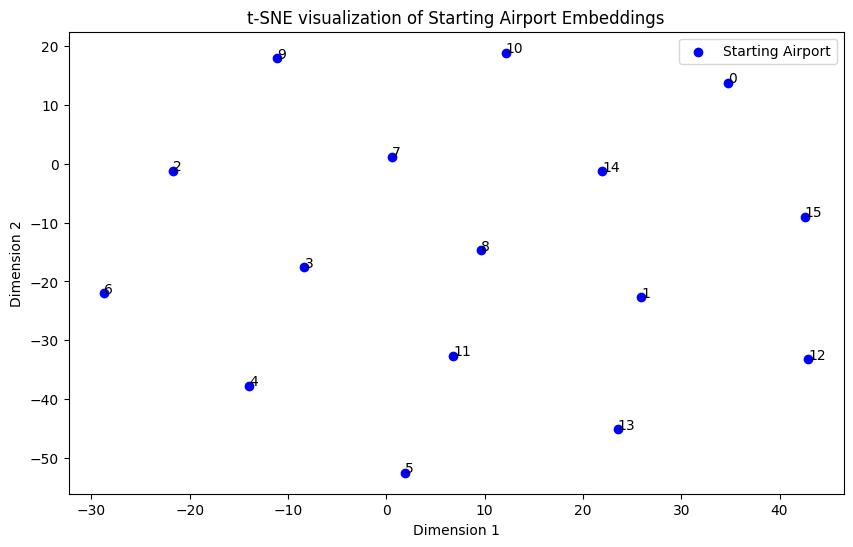

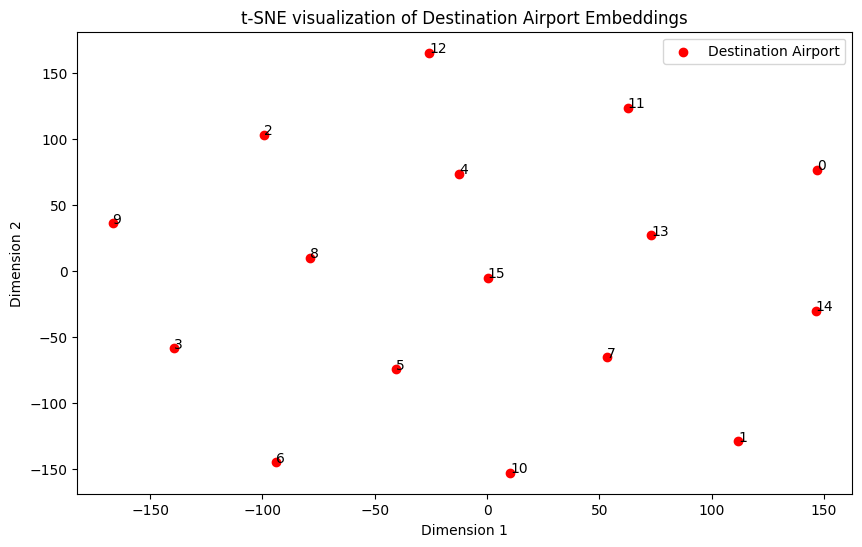

In [31]:
# Plot startingAirport embeddings
plt.figure(figsize=(10, 6))
plt.scatter(starting_airport_embeddings_2d[:, 0], starting_airport_embeddings_2d[:, 1], c='blue', label='Starting Airport')
for i, label in enumerate(range(starting_airport_embeddings.shape[0])):
    # Annotate the points with the airport from le
    # label = le.inverse_transform([label])[0]
    plt.annotate(label, (starting_airport_embeddings_2d[i, 0], starting_airport_embeddings_2d[i, 1]))
plt.title('t-SNE visualization of Starting Airport Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

# Plot destinationAirport embeddings
plt.figure(figsize=(10, 6))
plt.scatter(destination_airport_embeddings_2d[:, 0], destination_airport_embeddings_2d[:, 1], c='red', label='Destination Airport')
for i, label in enumerate(range(destination_airport_embeddings.shape[0])):
    # Annotate the points with the airport from le
    # label = le.inverse_transform([label])[0]
    plt.annotate(label, (destination_airport_embeddings_2d[i, 0], destination_airport_embeddings_2d[i, 1]))
plt.title('t-SNE visualization of Destination Airport Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [34]:
from scipy.spatial.distance import euclidean

# Function to calculate the distance between two airports
def calculate_distance(airport1, airport2, embeddings):
    return euclidean(embeddings[airport1], embeddings[airport2])

# Example: Calculate the distance between airport 0 and airport 1
distance = calculate_distance(9, 12, starting_airport_embeddings)
print(f"Distance between airport 0 and airport 1: {distance}")

Distance between airport 0 and airport 1: 3.362314224243164


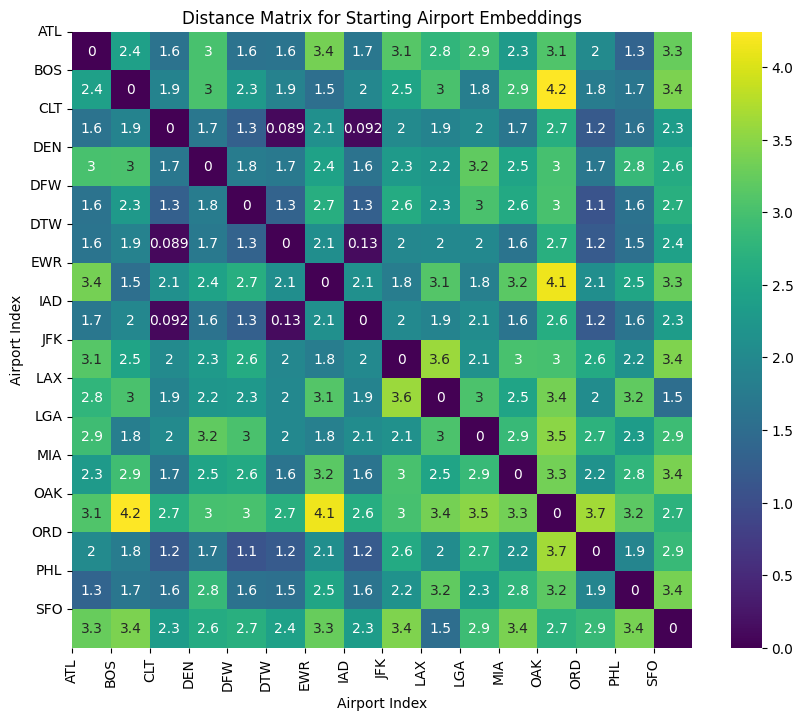

In [36]:
import numpy as np
import seaborn as sns

# Calculate the distance matrix for startingAirport embeddings
num_airports = starting_airport_embeddings.shape[0]
distance_matrix = np.zeros((num_airports, num_airports))

for i in range(num_airports):
    for j in range(num_airports):
        distance_matrix[i, j] = calculate_distance(i, j, starting_airport_embeddings)

# Plot the distance matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, annot=True, cmap='viridis')
plt.title('Distance Matrix for Starting Airport Embeddings')
#rename index using le
Airport_rename = {i: le.inverse_transform([i])[0] for i in range(starting_airport_embeddings.shape[0])}
plt.xticks(ticks=range(num_airports), labels=[Airport_rename[i] for i in range(num_airports)], rotation=90)
plt.yticks(ticks=range(num_airports), labels=[Airport_rename[i] for i in range(num_airports)], rotation=0)

plt.xlabel('Airport Index')
plt.ylabel('Airport Index')

# relabel index using le
plt.show()

In [37]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model
from scikeras.wrappers import KerasRegressor

# Sample data for demonstration
X_train = pd.DataFrame({
    'startingAirport': ['A', 'B', 'A', 'C', 'B'],
    'destinationAirport': ['X', 'Y', 'X', 'Z', 'Y'],
    'otherFeature1': [1, 2, 3, 4, 5],
    'otherFeature2': [5, 4, 3, 2, 1]
})
y_train = np.array([100, 200, 150, 300, 250])

X_test = pd.DataFrame({
    'startingAirport': ['A', 'B'],
    'destinationAirport': ['X', 'Y'],
    'otherFeature1': [1, 2],
    'otherFeature2': [5, 4]
})
y_test = np.array([120, 220])

# Define a function to create the Keras model
def create_model():
    startingAirport_input = Input(shape=(1,), name='startingAirport')
    destinationAirport_input = Input(shape=(1,), name='destinationAirport')
    other_features_input = Input(shape=(X_train.shape[1] - 2,), name='otherFeatures')
    print('other_features',other_features_input.shape)

    startingAirport_embedding = Embedding(input_dim=len(np.unique(X_train['startingAirport'])), output_dim=5)(startingAirport_input)
    destinationAirport_embedding = Embedding(input_dim=len(np.unique(X_train['destinationAirport'])), output_dim=5)(destinationAirport_input)
    

    startingAirport_flatten = Flatten()(startingAirport_embedding)
    destinationAirport_flatten = Flatten()(destinationAirport_embedding)



    concat = Concatenate()([startingAirport_flatten, destinationAirport_flatten, other_features_input])
    print('concat',concat.shape)
    
    dense1 = Dense(128, activation='relu')(concat)
    dense2 = Dense(64, activation='relu')(dense1)
    output = Dense(1)(dense2)

    model = Model(inputs=[startingAirport_input, destinationAirport_input, other_features_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

# Create the model
model = create_model()

# Print the model summary
model.summary()

# Print input layer configurations
for layer in model.layers:
    if layer.__class__.__name__ == 'InputLayer':
        for tensor in layer.input:
            print(f"Layer {layer.name} expects input shape: {tensor.shape}")

# Check the model's input shape attributes
for input_layer in model.inputs:
    print(f"Input layer {input_layer.name} expects shape: {input_layer.shape}")

# Wrap the Keras model with SciKeras
nn = KerasRegressor(model=create_model, epochs=10, batch_size=32)

# Ensure the input data is correctly formatted
X_train_formatted = [X_train['startingAirport'].values.reshape(-1, 1), X_train['destinationAirport'].values.reshape(-1, 1), X_train.drop(columns=['startingAirport', 'destinationAirport']).values]
X_test_formatted = [X_test['startingAirport'].values.reshape(-1, 1), X_test['destinationAirport'].values.reshape(-1, 1), X_test.drop(columns=['startingAirport', 'destinationAirport']).values]

# Print debug information
print("X_train_formatted shapes:", [x.shape for x in X_train_formatted])
print("X_train_formatted types:", [type(x) for x in X_train_formatted])
print("X_test_formatted shapes:", [x.shape for x in X_test_formatted])
print("X_test_formatted types:", [type(x) for x in X_test_formatted])

# Fit the model
nn.fit(X_train_formatted, y_train)

# Evaluate the model
score = nn.score(X_test_formatted, y_test)
print("Score:", score)

# Plot learning curve
pd.DataFrame(nn.model_.history.history).plot()

other_features (None, 2)
concat (None, 12)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ startingAirport     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ destinationAirport  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_18        │ (None, 1, 5)      │         15 │ startingAirport[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_19        │ (None, 1, 5)      │         15 │ destinationAirpo… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_18          │ (None, 5)         │          0 │ embedding_18[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_19          │ (None, 5)         │          0 │ embedding_19[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ otherFeatures       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 12)        │          0 │ flatten_18[0][0], │
│ (Concatenate)       │                   │            │ flatten_19[0][0], │
│                     │                   │            │ otherFeatures[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 128)       │      1,664 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 64)        │      8,256 │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 1)         │         65 │ dense_28[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,015 (39.12 KB)

 Trainable params: 10,015 (39.12 KB)

 Non-trainable params: 0 (0.00 B)

Input layer startingAirport expects shape: (None, 1)
Input layer destinationAirport expects shape: (None, 1)
Input layer otherFeatures expects shape: (None, 2)
X_train_formatted shapes: [(5, 1), (5, 1), (5, 2)]
X_train_formatted types: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
X_test_formatted shapes: [(2, 1), (2, 1), (2, 2)]
X_test_formatted types: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3, 5) + inhomogeneous part.

In [38]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model
from scikeras.wrappers import KerasRegressor

# Sample data for demonstration
X_train = pd.DataFrame({
    'startingAirport': ['A', 'B', 'A', 'C', 'B'],
    'destinationAirport': ['X', 'Y', 'X', 'Z', 'Y'],
    'otherFeature1': [1, 2, 3, 4, 5],
    'otherFeature2': [5, 4, 3, 2, 1]
})
y_train = np.array([100, 200, 150, 300, 250])

X_test = pd.DataFrame({
    'startingAirport': ['A', 'B'],
    'destinationAirport': ['X', 'Y'],
    'otherFeature1': [1, 2],
    'otherFeature2': [5, 4]
})
y_test = np.array([120, 220])

# Define a function to create the Keras model
def create_model():
    startingAirport_input = Input(shape=(1,), name='startingAirport')
    destinationAirport_input = Input(shape=(1,), name='destinationAirport')
    other_features_input = Input(shape=(X_train.shape[1] - 2,), name='otherFeatures')

    startingAirport_embedding = Embedding(input_dim=len(np.unique(X_train['startingAirport'])), output_dim=5)(startingAirport_input)
    destinationAirport_embedding = Embedding(input_dim=len(np.unique(X_train['destinationAirport'])), output_dim=5)(destinationAirport_input)

    startingAirport_flatten = Flatten()(startingAirport_embedding)
    destinationAirport_flatten = Flatten()(destinationAirport_embedding)

    concat = Concatenate()([startingAirport_flatten, destinationAirport_flatten, other_features_input])

    dense1 = Dense(128, activation='relu')(concat)
    dense2 = Dense(64, activation='relu')(dense1)
    output = Dense(1)(dense2)

    model = Model(inputs=[startingAirport_input, destinationAirport_input, other_features_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

# Create the model
model = create_model()

# Print the model summary
model.summary()

# Print input layer configurations
for layer in model.layers:
    if layer.__class__.__name__ == 'InputLayer':
        for tensor in layer.input:
            print(f"Layer {layer.name} expects input shape: {tensor.shape}")

# Check the model's input shape attributes
for input_layer in model.inputs:
    print(f"Input layer {input_layer.name} expects shape: {input_layer.shape}")

# Wrap the Keras model with SciKeras
nn = KerasRegressor(model=create_model, epochs=10, batch_size=32)

# Ensure the input data is correctly formatted
X_train_formatted = [
    X_train['startingAirport'].values.reshape(-1, 1),
    X_train['destinationAirport'].values.reshape(-1, 1),
    X_train.drop(columns=['startingAirport', 'destinationAirport']).values
]
X_test_formatted = [
    X_test['startingAirport'].values.reshape(-1, 1),
    X_test['destinationAirport'].values.reshape(-1, 1),
    X_test.drop(columns=['startingAirport', 'destinationAirport']).values
]

# Print debug information
print("X_train_formatted shapes:", [x.shape for x in X_train_formatted])
print("X_train_formatted types:", [type(x) for x in X_train_formatted])
print("X_test_formatted shapes:", [x.shape for x in X_test_formatted])
print("X_test_formatted types:", [type(x) for x in X_test_formatted])

# Check for NaN or infinite values
print("NaN values in X_train_formatted:", [np.isnan(x).any() for x in X_train_formatted])
print("Infinite values in X_train_formatted:", [np.isinf(x).any() for x in X_train_formatted])

# Print sample data
print("Sample X_train_formatted:", [x[:5] for x in X_train_formatted])
print("Sample y_train:", y_train[:5])

# Fit the model
nn.fit(X_train_formatted, y_train)

# Evaluate the model
score = nn.score(X_test_formatted, y_test)
print("Score:", score)

# Plot learning curve
pd.DataFrame(nn.model_.history.history).plot()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ startingAirport     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ destinationAirport  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_20        │ (None, 1, 5)      │         15 │ startingAirport[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_21        │ (None, 1, 5)      │         15 │ destinationAirpo… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_20          │ (None, 5)         │          0 │ embedding_20[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_21          │ (None, 5)         │          0 │ embedding_21[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ otherFeatures       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 12)        │          0 │ flatten_20[0][0], │
│ (Concatenate)       │                   │            │ flatten_21[0][0], │
│                     │                   │            │ otherFeatures[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 128)       │      1,664 │ concatenate_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 64)        │      8,256 │ dense_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 1)         │         65 │ dense_31[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,015 (39.12 KB)

 Trainable params: 10,015 (39.12 KB)

 Non-trainable params: 0 (0.00 B)

Input layer startingAirport expects shape: (None, 1)
Input layer destinationAirport expects shape: (None, 1)
Input layer otherFeatures expects shape: (None, 2)
X_train_formatted shapes: [(5, 1), (5, 1), (5, 2)]
X_train_formatted types: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
X_test_formatted shapes: [(2, 1), (2, 1), (2, 2)]
X_test_formatted types: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [39]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model
from scikeras.wrappers import KerasRegressor

# Sample data for demonstration
X_train = pd.DataFrame({
    'startingAirport': ['A', 'B', 'A', 'C', 'B'],
    'destinationAirport': ['X', 'Y', 'X', 'Z', 'Y'],
    'otherFeature1': [1, 2, 3, 4, 5],
    'otherFeature2': [5, 4, 3, 2, 1]
})
y_train = np.array([100, 200, 150, 300, 250])

X_test = pd.DataFrame({
    'startingAirport': ['A', 'B'],
    'destinationAirport': ['X', 'Y'],
    'otherFeature1': [1, 2],
    'otherFeature2': [5, 4]
})
y_test = np.array([120, 220])

# Convert categorical columns to numerical values
le_starting = LabelEncoder()
le_destination = LabelEncoder()

X_train['startingAirport'] = le_starting.fit_transform(X_train['startingAirport'])
X_train['destinationAirport'] = le_destination.fit_transform(X_train['destinationAirport'])

X_test['startingAirport'] = le_starting.transform(X_test['startingAirport'])
X_test['destinationAirport'] = le_destination.transform(X_test['destinationAirport'])

# Define a function to create the Keras model
def create_model():
    startingAirport_input = Input(shape=(1,), name='startingAirport')
    destinationAirport_input = Input(shape=(1,), name='destinationAirport')
    other_features_input = Input(shape=(X_train.shape[1] - 2,), name='otherFeatures')

    startingAirport_embedding = Embedding(input_dim=len(np.unique(X_train['startingAirport'])), output_dim=5)(startingAirport_input)
    destinationAirport_embedding = Embedding(input_dim=len(np.unique(X_train['destinationAirport'])), output_dim=5)(destinationAirport_input)

    startingAirport_flatten = Flatten()(startingAirport_embedding)
    destinationAirport_flatten = Flatten()(destinationAirport_embedding)

    concat = Concatenate()([startingAirport_flatten, destinationAirport_flatten, other_features_input])

    dense1 = Dense(128, activation='relu')(concat)
    dense2 = Dense(64, activation='relu')(dense1)
    output = Dense(1)(dense2)

    model = Model(inputs=[startingAirport_input, destinationAirport_input, other_features_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

# Create the model
model = create_model()

# Print the model summary
model.summary()

# Print input layer configurations
for layer in model.layers:
    if layer.__class__.__name__ == 'InputLayer':
        for tensor in layer.input:
            print(f"Layer {layer.name} expects input shape: {tensor.shape}")

# Check the model's input shape attributes
for input_layer in model.inputs:
    print(f"Input layer {input_layer.name} expects shape: {input_layer.shape}")

# Wrap the Keras model with SciKeras
nn = KerasRegressor(model=create_model, epochs=10, batch_size=32)

# Ensure the input data is correctly formatted
X_train_formatted = [
    X_train['startingAirport'].values.reshape(-1, 1),
    X_train['destinationAirport'].values.reshape(-1, 1),
    X_train.drop(columns=['startingAirport', 'destinationAirport']).values
]
X_test_formatted = [
    X_test['startingAirport'].values.reshape(-1, 1),
    X_test['destinationAirport'].values.reshape(-1, 1),
    X_test.drop(columns=['startingAirport', 'destinationAirport']).values
]

# Print debug information
print("X_train_formatted shapes:", [x.shape for x in X_train_formatted])
print("X_train_formatted types:", [type(x) for x in X_train_formatted])
print("X_test_formatted shapes:", [x.shape for x in X_test_formatted])
print("X_test_formatted types:", [type(x) for x in X_test_formatted])

# Check for NaN or infinite values
print("NaN values in X_train_formatted:", [np.isnan(x).any() for x in X_train_formatted])
print("Infinite values in X_train_formatted:", [np.isinf(x).any() for x in X_train_formatted])

# Print sample data
print("Sample X_train_formatted:", [x[:5] for x in X_train_formatted])
print("Sample y_train:", y_train[:5])

# Fit the model
nn.fit(X_train_formatted, y_train)

# Evaluate the model
score = nn.score(X_test_formatted, y_test)
print("Score:", score)

# Plot learning curve
pd.DataFrame(nn.model_.history.history).plot()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ startingAirport     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ destinationAirport  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_22        │ (None, 1, 5)      │         15 │ startingAirport[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_23        │ (None, 1, 5)      │         15 │ destinationAirpo… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_22          │ (None, 5)         │          0 │ embedding_22[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_23          │ (None, 5)         │          0 │ embedding_23[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ otherFeatures       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 12)        │          0 │ flatten_22[0][0], │
│ (Concatenate)       │                   │            │ flatten_23[0][0], │
│                     │                   │            │ otherFeatures[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 128)       │      1,664 │ concatenate_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 64)        │      8,256 │ dense_33[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 1)         │         65 │ dense_34[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,015 (39.12 KB)

 Trainable params: 10,015 (39.12 KB)

 Non-trainable params: 0 (0.00 B)

Input layer startingAirport expects shape: (None, 1)
Input layer destinationAirport expects shape: (None, 1)
Input layer otherFeatures expects shape: (None, 2)
X_train_formatted shapes: [(5, 1), (5, 1), (5, 2)]
X_train_formatted types: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
X_test_formatted shapes: [(2, 1), (2, 1), (2, 2)]
X_test_formatted types: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
NaN values in X_train_formatted: [False, False, False]
Infinite values in X_train_formatted: [False, False, False]
Sample X_train_formatted: [array([[0],
       [1],
       [0],
       [2],
       [1]]), array([[0],
       [1],
       [0],
       [2],
       [1]]), array([[1, 5],
       [2, 4],
       [3, 3],
       [4, 2],
       [5, 1]])]
Sample y_train: [100 200 150 300 250]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3, 5) + inhomogeneous part.

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ startingAirport     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ destinationAirport  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_24        │ (None, 1, 5)      │         15 │ startingAirport[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_25        │ (None, 1, 5)      │         15 │ destinationAirpo… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_24          │ (None, 5)         │          0 │ embedding_24[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_25          │ (None, 5)         │          0 │ embedding_25[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ otherFeatures       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 12)        │          0 │ flatten_24[0][0], │
│ (Concatenate)       │                   │            │ flatten_25[0][0], │
│                     │                   │            │ otherFeatures[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 128)       │      1,664 │ concatenate_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 64)        │      8,256 │ dense_36[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 1)         │         65 │ dense_37[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,015 (39.12 KB)

 Trainable params: 10,015 (39.12 KB)

 Non-trainable params: 0 (0.00 B)

Input layer startingAirport expects shape: (None, 1)
Input layer destinationAirport expects shape: (None, 1)
Input layer otherFeatures expects shape: (None, 2)
X_train_formatted shapes: [(5, 1), (5, 1), (5, 2)]
X_train_formatted types: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
X_test_formatted shapes: [(2, 1), (2, 1), (2, 2)]
X_test_formatted types: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
NaN values in X_train_formatted: [False, False, False]
Infinite values in X_train_formatted: [False, False, False]
Sample X_train_formatted: [array([[0],
       [1],
       [0],
       [2],
       [1]]), array([[0],
       [1],
       [0],
       [2],
       [1]]), array([[1, 5],
       [2, 4],
       [3, 3],
       [4, 2],
       [5, 1]])]
Sample y_train: [100 200 150 300 250]
Epoch 1/10


/home/raytechie/Projects/adv_mla_at3/ml_experimentation/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['startingAirport', 'destinationAirport', 'otherFeatures']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 44876.1250 - val_loss: 31308.4023
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 44816.5312 - val_loss: 31258.3770
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 44758.4258 - val_loss: 31214.7812
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 44702.5078 - val_loss: 31173.3730
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 44648.3398 - val_loss: 31132.3594
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 44594.8516 - val_loss: 31091.3496
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 44541.8047 - val_loss: 31051.0879
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 44489.0312 - val_loss: 31012.5410
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 44436.9531 - val_loss: 30974.8926
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 44384.6172 - val_loss: 30935.1797
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 30935.1797
Score: 30935.1796875


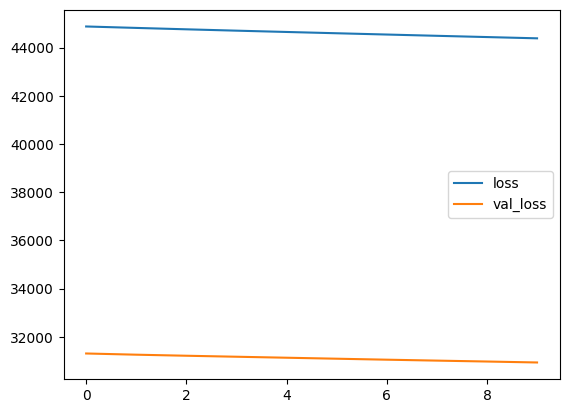

In [40]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Sample data for demonstration
X_train = pd.DataFrame({
    'startingAirport': ['A', 'B', 'A', 'C', 'B'],
    'destinationAirport': ['X', 'Y', 'X', 'Z', 'Y'],
    'otherFeature1': [1, 2, 3, 4, 5],
    'otherFeature2': [5, 4, 3, 2, 1]
})
y_train = np.array([100, 200, 150, 300, 250])

X_test = pd.DataFrame({
    'startingAirport': ['A', 'B'],
    'destinationAirport': ['X', 'Y'],
    'otherFeature1': [1, 2],
    'otherFeature2': [5, 4]
})
y_test = np.array([120, 220])

# Convert categorical columns to numerical values
le_starting = LabelEncoder()
le_destination = LabelEncoder()

X_train['startingAirport'] = le_starting.fit_transform(X_train['startingAirport'])
X_train['destinationAirport'] = le_destination.fit_transform(X_train['destinationAirport'])

X_test['startingAirport'] = le_starting.transform(X_test['startingAirport'])
X_test['destinationAirport'] = le_destination.transform(X_test['destinationAirport'])

# Define a function to create the Keras model
def create_model():
    startingAirport_input = Input(shape=(1,), name='startingAirport')
    destinationAirport_input = Input(shape=(1,), name='destinationAirport')
    other_features_input = Input(shape=(X_train.shape[1] - 2,), name='otherFeatures')

    startingAirport_embedding = Embedding(input_dim=len(np.unique(X_train['startingAirport'])), output_dim=5)(startingAirport_input)
    destinationAirport_embedding = Embedding(input_dim=len(np.unique(X_train['destinationAirport'])), output_dim=5)(destinationAirport_input)

    startingAirport_flatten = Flatten()(startingAirport_embedding)
    destinationAirport_flatten = Flatten()(destinationAirport_embedding)

    concat = Concatenate()([startingAirport_flatten, destinationAirport_flatten, other_features_input])

    dense1 = Dense(128, activation='relu')(concat)
    dense2 = Dense(64, activation='relu')(dense1)
    output = Dense(1)(dense2)

    model = Model(inputs=[startingAirport_input, destinationAirport_input, other_features_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

# Create the model
model = create_model()

# Print the model summary
model.summary()

# Print input layer configurations
for layer in model.layers:
    if layer.__class__.__name__ == 'InputLayer':
        for tensor in layer.input:
            print(f"Layer {layer.name} expects input shape: {tensor.shape}")

# Check the model's input shape attributes
for input_layer in model.inputs:
    print(f"Input layer {input_layer.name} expects shape: {input_layer.shape}")

# Ensure the input data is correctly formatted
X_train_formatted = [
    X_train['startingAirport'].values.reshape(-1, 1),
    X_train['destinationAirport'].values.reshape(-1, 1),
    X_train.drop(columns=['startingAirport', 'destinationAirport']).values
]
X_test_formatted = [
    X_test['startingAirport'].values.reshape(-1, 1),
    X_test['destinationAirport'].values.reshape(-1, 1),
    X_test.drop(columns=['startingAirport', 'destinationAirport']).values
]

# Print debug information
print("X_train_formatted shapes:", [x.shape for x in X_train_formatted])
print("X_train_formatted types:", [type(x) for x in X_train_formatted])
print("X_test_formatted shapes:", [x.shape for x in X_test_formatted])
print("X_test_formatted types:", [type(x) for x in X_test_formatted])

# Check for NaN or infinite values
print("NaN values in X_train_formatted:", [np.isnan(x).any() for x in X_train_formatted])
print("Infinite values in X_train_formatted:", [np.isinf(x).any() for x in X_train_formatted])

# Print sample data
print("Sample X_train_formatted:", [x[:5] for x in X_train_formatted])
print("Sample y_train:", y_train[:5])

# Fit the model
history = model.fit(X_train_formatted, y_train, epochs=10, batch_size=32, validation_data=(X_test_formatted, y_test))

# Evaluate the model
score = model.evaluate(X_test_formatted, y_test)
print("Score:", score)

# Plot learning curve
pd.DataFrame(history.history).plot()
plt.show()

In [17]:
########################################################################################################################
# 3. Create Pipelines
########################################################################################################################
# Standard Scaler
preprocessing = [('scaler', StandardScaler())]

# Scikitlearn Pipelines
# Linear Regression Pipeline
sklearn_pipeline= Pipeline(preprocessing + [('model', linear_regression)])

# LightGBM Pipeline
lgbm_pipeline = Pipeline(preprocessing + [('model', lgbm)])

# Tensorflow Pipeline
tf_pipeline = Pipeline(preprocessing + [('model', nn)])


In [20]:
########################################################################################################################
# 4. Train and Evaluate Pipleines
########################################################################################################################
# Linear Regression
sklearn_pipeline.fit(X_train, y_train)
sklearn_pipeline.score(X_test, y_test)

# LightGBM
lgbm_pipeline.fit(X_train, y_train)
lgbm_pipeline.score(X_test, y_test)



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 5255408, number of used features: 9
[LightGBM] [Info] Start training from score 331.521755


0.6213505654229615

In [23]:
# Tensorflow
tf_pipeline.fit(X_train, y_train)
tf_pipeline.score(X_test, y_test)
# Plot learning curve
pd.DataFrame(tf_pipeline.model.history.history).plot()

Epoch 1/10


ValueError: Layer "functional_1" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(None, 9) dtype=float32>]

In [ ]:



########################################################################################################################
# 5. Save the model
########################################################################################################################

joblib.dump(sklearn_pipeline, '../models/linear_regression.pkl')
joblib.dump(lgbm_pipeline, '../models/lgbm.pkl')
tf_pipeline.model.save('../models/tf_nn.h5')

########################################################################################################################
# 5. Load the model
########################################################################################################################
import joblib
from tensorflow.keras.models import load_model

sklearn_pipeline = joblib.load('../models/linear_regression.pkl')
lgbm_pipeline = joblib.load('../models/lgbm.pkl')
tf_pipeline = load_model('../models/tf_nn.h5')







